In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gc
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model
from keras.utils import plot_model

Using TensorFlow backend.


In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Import Google Drive for file stream

In [5]:
from google.colab import drive
drive.mount('/content/drive')
csv_path='/content/drive/My Drive/TCS/text_emotion.csv'
EMBEDDING_FILE='/content/drive/My Drive/TCS/glove.twitter.27B.25d.txt'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#df=pd.read_csv("text_emotion.csv")   
df=pd.read_csv(csv_path)

In [7]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


# Data cleaning

In [8]:
df=df.drop(['tweet_id','author'],axis=1) 
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [9]:
df.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [10]:
def clean(df):
    line=df['content'].values.tolist()
    all_content=list()
    for text in line:
        text=text.lower()#converting all charectrers in lower case
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        pattern=re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-f][0-9a-fA-F]))+')
        text=pattern.sub("",text)
        text=re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]","",text)
        tokens=word_tokenize(text)
        table=str.maketrans('','',string.punctuation)
        stripped=[w.translate(table) for w in tokens]
        words=[word for word in stripped if word.isalpha()]
        stop_word=set(stopwords.words("english"))
        stop_word.discard("not")
        ps=PorterStemmer()
        words=[ps.stem(w) for w in words if not w in stop_word]
        words=' '.join(words)
        all_content.append(words)
    return all_content


In [11]:
all_review=clean(df)

In [12]:
all_review[0:5]

['tiffanylu know listenin bad habit earlier start freakin part',
 'layin n bed headach ughhhhwaitin call',
 'funer ceremonygloomi friday',
 'want hang friend soon',
 'dannycastillo want trade someon houston ticket one']

# Preprocessing

In [13]:
dummies=pd.get_dummies(df.sentiment)
y = dummies.values

In [14]:
y[0:5]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [15]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(all_review))
list_tokenized_train = tokenizer.texts_to_sequences(all_review)
list_tokenized_test = tokenizer.texts_to_sequences(all_review)

In [16]:
list_tokenized_test [0]

[16, 2622, 63, 3329, 655, 80, 960, 359]

(array([3.410e+02, 1.640e+03, 3.239e+03, 3.986e+03, 4.217e+03, 4.162e+03,
        3.805e+03, 3.431e+03, 3.128e+03, 2.703e+03, 2.442e+03, 2.100e+03,
        1.747e+03, 1.271e+03, 7.860e+02, 4.910e+02, 2.750e+02, 1.300e+02,
        5.300e+01, 3.200e+01, 1.500e+01, 5.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

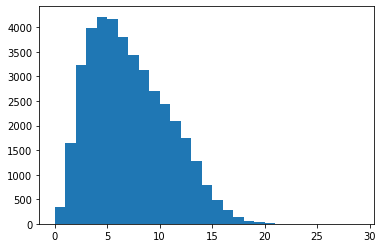

In [17]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,30,1))

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_t, y_te = train_test_split(list_tokenized_test, y, test_size= 0.1, random_state = 1)

In [22]:
maxlen = 15
X_t = pad_sequences(X_train, maxlen=maxlen)
X_te = pad_sequences(X_test, maxlen=maxlen)

# Embedding weights

In [23]:
embed_size = 25
embeddings_index = dict()
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs #50 dimensions
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
gc.collect() 
all_embs = np.hstack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()
nb_words = len(tokenizer.word_index)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
gc.collect()
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        embeddedCount+=1
print('total embedded:',embeddedCount,'common words')
del(embeddings_index)
gc.collect()

Loaded 1193514 word vectors.
total embedded: 16299 common words


0

In [24]:
embedding_matrix.shape

(41182, 25)

# LSTM Layer

In [25]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(13, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

# Model fitting

In [26]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
batch_size =15
epochs = 5
history=model.fit(X_t,y_t, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 32400 samples, validate on 3600 samples
Epoch 1/5
32400/32400 [==============================] - 33s 1ms/step - loss: 0.2462 - accuracy: 0.9209 - val_loss: 0.2348 - val_accuracy: 0.9231
Epoch 2/5
32400/32400 [==============================] - 32s 989us/step - loss: 0.2364 - accuracy: 0.9231 - val_loss: 0.2312 - val_accuracy: 0.9231
Epoch 3/5
32400/32400 [==============================] - 32s 991us/step - loss: 0.2324 - accuracy: 0.9232 - val_loss: 0.2285 - val_accuracy: 0.9233
Epoch 4/5
32400/32400 [==============================] - 32s 983us/step - loss: 0.2280 - accuracy: 0.9233 - val_loss: 0.2248 - val_accuracy: 0.9236


# Model accuracy plot

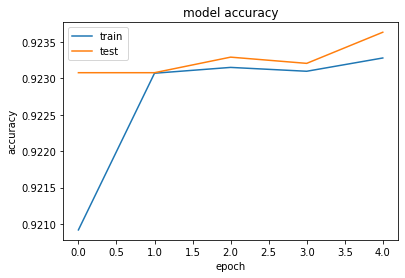

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Architecture

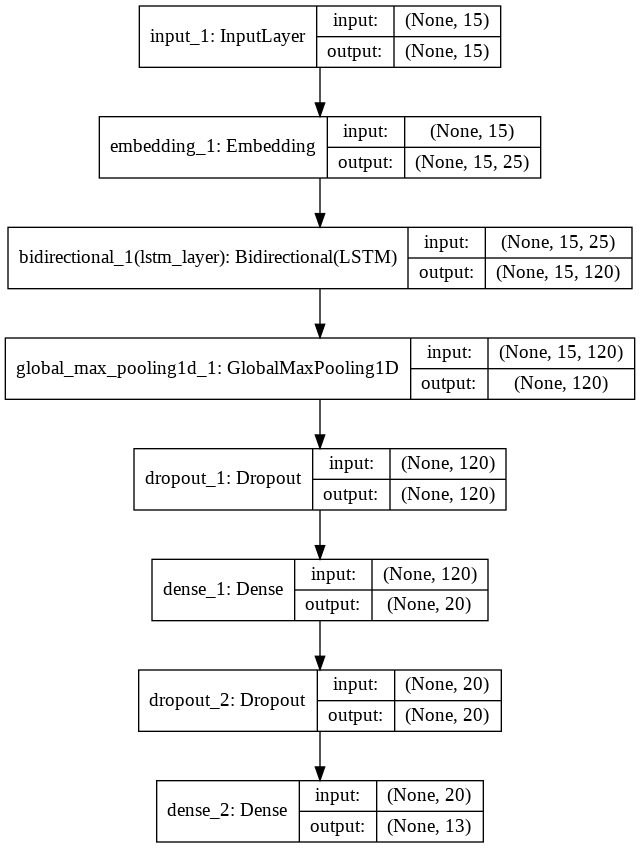

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)